# CIFAR-10

**Task description:** Take the CIFAR-10 dataset. Train a network, which is able to predict for a given input image whether an animal or a vessel is included, and whether the depicted object can fly, walk, jump or swim.

**Groud truth:**


| label |  name  | animal or vessel  | fly, walk, jump, or swim  |
|---|---|---|---|
| 0  |airplane | none | fly |
| 1  |automobile | none | none |
| 2  |bird | animal | fly, walk, jump |
| 3  |cat | animal | walk, jump, swim |
| 4  |deer | animal | walk, jump, swim |
| 5  |dog | animal | walk, jump, swim |
| 6  |frog | animal | jump, swim |
| 7  |horse | animal | walk, jump, swim |
| 8  |ship | vessel | swim |
| 9  |truck | none | none |

In [1]:
label_map = {
    0: {
        "label_name": "airplane",
        "animal_vessel": "none",
        "movement": ["fly"],
    },
    1: {
        "label_name": "automobile",
        "animal_vessel": "none",
        "movement": ["none"],
    },
    2: {
        "label_name": "bird",
        "animal_vessel": "animal",
        "movement": ["fly", "walk", "jump"],
    },
    3: {
        "label_name": "cat",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    4: {
        "label_name": "deer",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    5: {
        "label_name": "dog",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    6: {
        "label_name": "frog",
        "animal_vessel": "animal",
        "movement": ["jump", "swim"],
    },
    7: {
        "label_name": "horse",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    8: {
        "label_name": "ship",
        "animal_vessel": "vessel",
        "movement": ["swim"],
    },
    9: {
        "label_name": "truck",
        "animal_vessel": "none",
        "movement": ["none"]
    }
}
movement_map = {
    "fly": 0,
    "walk": 1,
    "jump": 2,
    "swim": 3,
    "none": 4
}
animal_vessel_map = {
    "animal": 0,
    "vessel": 1,
    "none": 2
}

In [2]:
def transform_target(y):
    animal_vessel_idx = animal_vessel_map[label_map[y]["animal_vessel"]]
    movement_idx = [movement_map[m] for m in label_map[y]["movement"]]
    return {
        "animal_vessel": torch.tensor(animal_vessel_idx),
        "movement": torch.zeros(5, dtype=torch.float).scatter_(0, torch.tensor(movement_idx), value=1)
    }

In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.CIFAR10(
    root="/tmp",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: transform_target(y))
)
test_data = datasets.CIFAR10(
    root="/tmp",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: transform_target(y))
)

Files already downloaded and verified
Files already downloaded and verified


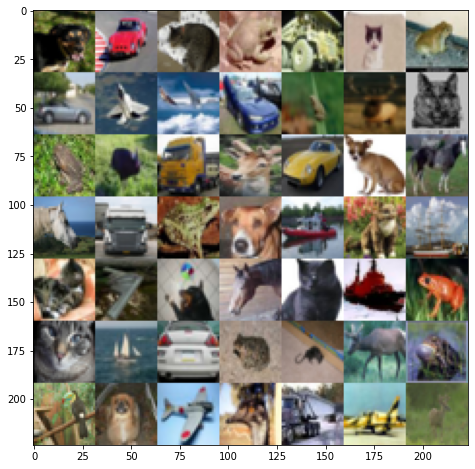

In [4]:
import matplotlib.pyplot as plt

n = 49
sample = torch.stack([training_data[i.item()][0] for i in torch.randint(0, len(training_data), (n, ))])
plt.figure(figsize=(8, 8))
plt.imshow(torch.hstack(torch.unbind(sample.movedim(1, 3).reshape(int(n**(1/2)), -1, 32, 3))))

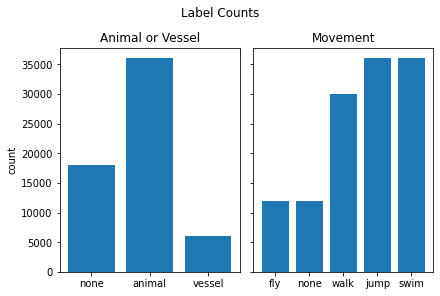

In [5]:
# label distribution can be computed based on the frequencies of the original labels
# https://www.cs.toronto.edu/~kriz/cifar.html
import collections

images_per_class = 5000 + 1000
animal_vessel_freq = collections.defaultdict(int)
movement_freq = collections.defaultdict(int)
for label in label_map.values():
    animal_vessel_freq[label["animal_vessel"]] += images_per_class
    for m in label["movement"]:
        movement_freq[m] += images_per_class

fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True)
ax[0].bar(range(len(animal_vessel_freq)), list(animal_vessel_freq.values()), tick_label=list(animal_vessel_freq.keys()))
ax[1].bar(range(len(movement_freq)), list(movement_freq.values()), tick_label=list(movement_freq.keys()))
ax[0].set_ylabel("count")
ax[0].set_title("Animal or Vessel")
ax[1].set_title("Movement")
fig.suptitle("Label Counts")
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SmallAlexNet(nn.Module):
    # https://en.wikipedia.org/wiki/AlexNet
    def __init__(self, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 120, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.feedforward = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(120 * 6 * 6, 84),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(84, 10),
            nn.ReLU(inplace=True)
        )
        self.animal_vessel = nn.Sequential(
            nn.Linear(10, 3),
            #nn.Softmax(inplace=True)
        )
        self.movement = nn.Sequential(
            nn.Linear(10, 5),
            #nn.Sigmoid(inplace=True)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.feedforward(x)
        return {
            "animal_vessel": self.animal_vessel(x),
            "movement": self.movement(x),
        }

In [7]:
def loss_fn(output, target):
    cross_entropy = F.cross_entropy(output["animal_vessel"], target["animal_vessel"])
    binary_cross_entropy = F.binary_cross_entropy_with_logits(output["movement"], target["movement"])
    return cross_entropy + binary_cross_entropy

In [75]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score

def calculate_metrics(pred, target, threshold=0.5):
    pred_animal_vessel = pred["animal_vessel"].argmax(axis=1)
    pred_movement = np.array(pred["movement"] > threshold, dtype=float)
    average_params = ["micro", "macro", "samples"]
    animal_vessel_metrics = {}
    movement_metrics = {}
    for ap in average_params:
        if ap != "samples":
            animal_vessel_metrics.update({
                f"precision_{ap}": precision_score(target["animal_vessel"], pred_animal_vessel, average=ap, zero_division=0),
                f"recall_{ap}": recall_score(target["animal_vessel"], pred_animal_vessel, average=ap, zero_division=0),
                f"f1_{ap}": f1_score(target["animal_vessel"], pred_animal_vessel, average=ap, zero_division=0),
            })
        movement_metrics.update({
            f"precision_{ap}": precision_score(target["movement"], pred_movement, average=ap, zero_division=0),
            f"recall_{ap}": recall_score(target["movement"], pred_movement, average=ap, zero_division=0),
            f"f1_{ap}": f1_score(target["movement"], pred_movement, average=ap, zero_division=0)
        })
    return {
        "animal_vessel": animal_vessel_metrics,
        "movement": movement_metrics
    }

In [79]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            animal_vessel_pred = pred["animal_vessel"]
            correct += (animal_vessel_pred.argmax(1) == y["animal_vessel"]).type(torch.float).sum().item()
            
            metrics = calculate_metrics(pred, y)
            animal_vessel_f1 = metrics["animal_vessel"]["f1_micro"]
            movement_f1 = metrics["movement"]["f1_micro"]
    
    test_loss /= num_batches
    correct /= size
    animal_vessel_f1 /= num_batches
    movement_f1 /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, Animal Vessel f1 {animal_vessel_f1:>8f}, Movement f1 {movement_f1:>8f} \n")
    

In [80]:
from torch.utils.data import DataLoader

learning_rate = 1e-3
batch_size = 64
epochs = 5

model = SmallAlexNet()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [81]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 1.696611  [    0/50000]
loss: 1.693346  [ 6400/50000]
loss: 1.724007  [12800/50000]
loss: 1.655151  [19200/50000]
loss: 1.694997  [25600/50000]
loss: 1.667552  [32000/50000]
loss: 1.688620  [38400/50000]
loss: 1.628598  [44800/50000]
Test Error: 
 Accuracy: 60.0%, Avg loss: 1.659390, Animal Vessel f1 0.003981, Movement f1 0.000000 

Epoch 2
-------------------------------
loss: 1.614348  [    0/50000]
loss: 1.621074  [ 6400/50000]
loss: 1.680972  [12800/50000]
loss: 1.588374  [19200/50000]
loss: 1.651693  [25600/50000]
loss: 1.619660  [32000/50000]
loss: 1.657889  [38400/50000]
loss: 1.578231  [44800/50000]
Test Error: 
 Accuracy: 60.0%, Avg loss: 1.623369, Animal Vessel f1 0.003981, Movement f1 0.000000 

Epoch 3
-------------------------------
loss: 1.566150  [    0/50000]
loss: 1.578182  [ 6400/50000]
loss: 1.656675  [12800/50000]
loss: 1.548459  [19200/50000]
loss: 1.623665  [25600/50000]
loss: 1.588924  [32000/50000]
loss: 1.639601  [3